In [8]:
import os
import sys
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from deuces import Card, Evaluator
from multiprocessing import Pool, cpu_count

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import KFold

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

sys.path.append('../src')
from calc_preflop_rank import evaluate2
from get_stats import get_player_stats
from monte_carlo import run_monte_carlo

data1 = pd.read_csv('../data/archive_parsed.csv')
data2 = pd.read_csv('../data/pluribus_parsed.csv')

data = pd.concat([data1, data2], ignore_index=True)

In [9]:
'''
Features:
 - player 1-6 stats
 - hole cards
 - community cards
 - preflop hand rating
 - postflop hand rating
'''

evaluator = Evaluator()

def convert_to_deuces_format(card_str):
    if card_str.startswith('10'):
        card_str = 'T' + card_str[2:]
    return Card.new(card_str)

def extract_features(row):
    features = []
    flop_cards = str(row['flop_cards']).split() if pd.notna(row['flop_cards']) and row['flop_cards'] else []
    turn_card = [str(row['turn_card'])] if pd.notna(row['turn_card']) and row['turn_card'] else []
    river_card = [str(row['river_card'])] if pd.notna(row['river_card']) and row['river_card'] else []
    
    if not isinstance(row['hole_cards'], str) or row['hole_cards'].strip() == '':
        return [0] * 41
    
    community_cards = [convert_to_deuces_format(card) for card in flop_cards + turn_card + river_card] if len(flop_cards) > 0 else []

    hole_cards_dict = dict([player.split(': ') for player in row['hole_cards'].split(', ')])
      
    for i in range(5):
        features.append(community_cards[i] if i < len(community_cards) else 0)
    
    players = row['players'].split(', ')
    for i in range(9):
        if i < len(players):
            player = players[i]
            player_stats = get_player_stats(player)
            features.extend(player_stats)
        else:
            features.extend([0] * 4)

    for player, cards in hole_cards_dict.items():
        if player is not ('Pluribus' or 'IlxxxlI'):
            continue
        
        player_hole_cards = [convert_to_deuces_format(card) for card in cards.split()]
        
        for card in player_hole_cards:
            features.append(card)
            
        features.append(evaluate2(cards))
        
        if len(community_cards) == 0:
            features.append(0)
        else:
            features.append(evaluator.evaluate(player_hole_cards, community_cards))
            
    return features

def extract_features_with_error_handling(row):
    try:
        return extract_features(row)
    except Exception as e:
        print(f"Error processing hand_id {row['hand_id']}: {e}")
        raise

In [3]:
def extract_labels(row):
    labels = []
    for winner in row['winners'].split(', '):
        if winner.split(': ')[0] in ['Pluribus', 'IlxxxlI']:
            labels.append(1)
        else:
            labels.append(0)
    return 1 if any(labels) else 0

In [4]:
X = np.array([extract_features_with_error_handling(row) for _, row in data.iterrows()])
y = np.array([extract_labels(row) for _, row in data.iterrows()])

print(X.shape)
print(y.shape)

print(f"Number of positives (1s): {np.sum(y)}")
print(f"Number of negatives (0s): {np.sum(1 - y)}")

(62154, 41)
(62154,)
Number of positives (1s): 9914
Number of negatives (0s): 52240


In [7]:
class HyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()
        
        model.add(Dense(units=hp.Int('units_input', min_value=64, max_value=256, step=64), 
                        input_dim=self.input_dim, activation='relu'))
        
        if hp.Boolean('use_dropout_input'):
            model.add(Dropout(rate=hp.Float('dropout_input', 0.0, 0.5, step=0.1)))
        
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32), 
                            activation='relu'))
            if hp.Boolean(f'use_dropout_{i}'):
                model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))
        
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
        
        return model

In [6]:
kf = KFold(n_splits=8, shuffle=True, random_state=42)

all_results = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Processing fold {fold + 1}")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    tuner = RandomSearch(
        HyperModel(input_dim=X_train.shape[1]),
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory=f'my_dir_fold_{fold + 1}',
        project_name='mlp_poker_winner'
    )

    tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

    best_model = tuner.get_best_models(num_models=1)[0]

    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters for fold {fold + 1}: {best_hp.values}")

    best_hp_values = best_hp.values
    val_accuracy = tuner.oracle.get_best_trials(num_trials=1)[0].score
    all_results.append({
        'fold': fold + 1,
        'best_hp': best_hp_values,
        'val_accuracy': val_accuracy
    })

with open('all_results.json', 'w') as f:
    json.dump(all_results, f, indent=4)

print("Cross-validation complete.")

Trial 3 Complete [00h 01m 35s]
val_accuracy: 0.7468627393245697

Best val_accuracy So Far: 0.7577064335346222
Total elapsed time: 00h 04m 40s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
256               |128               |units_input
False             |True              |use_dropout_input
1                 |1                 |num_layers
64                |64                |units_0
False             |False             |use_dropout_0
0.0001            |0.001             |learning_rate
128               |32                |units_1
True              |False             |use_dropout_1
128               |32                |units_2
False             |True              |use_dropout_2
0.2               |0                 |dropout_input

Epoch 1/20
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 3s 926us/step - accuracy: 0.5123 - loss: 142285.3750 - val_accuracy: 0.4338 - val_loss: 70413.6797
Epoch 2/20
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - accuracy: 0.5343 - loss: 

KeyboardInterrupt: 

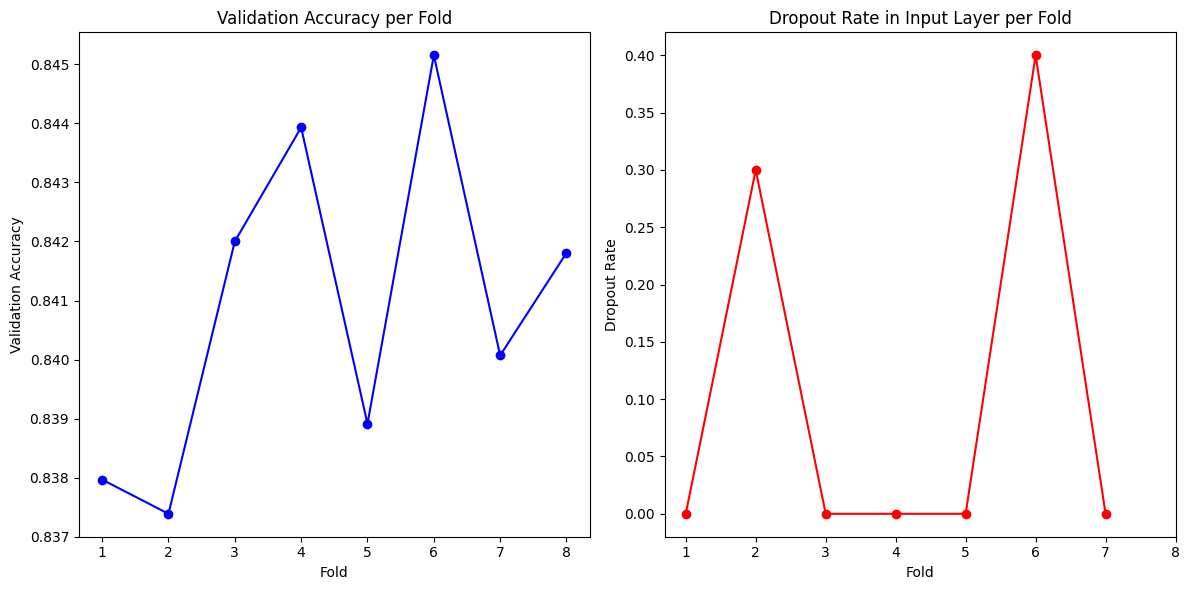

In [10]:
with open('all_results.json', 'r') as f:
    results = json.load(f)

folds = [result['fold'] for result in results]
val_accuracies = [result['val_accuracy'] for result in results]
dropout_rates = [hp.get('dropout_input', None) for hp in [result['best_hp'] for result in results]]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(folds, val_accuracies, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.xticks(folds)

plt.subplot(1, 2, 2)
plt.plot(folds, dropout_rates, marker='o', linestyle='-', color='r')
plt.title('Dropout Rate in Input Layer per Fold')
plt.xlabel('Fold')
plt.ylabel('Dropout Rate')
plt.xticks(folds)

plt.tight_layout()
plt.show()

In [11]:
#Reconstructing best model from save, didn't want to retrain and save differently because it takes so long

oracle_path = 'my_dir_fold_6/mlp_poker_winner/oracle.json'
with open(oracle_path, 'r') as f:
    oracle_data = json.load(f)

best_trial = None
best_score = -float('inf')

for trial_id in oracle_data['id_to_hash'].keys():
    trial_dir = f'my_dir_fold_6/mlp_poker_winner/trial_{trial_id}'
    trial_json_path = os.path.join(trial_dir, 'trial.json')
    
    with open(trial_json_path, 'r') as f:
        trial_data = json.load(f)
    
    score = trial_data.get('score', -1)
    
    if score > best_score:
        best_score = score
        best_trial = trial_id

print(f"Best trial: {best_trial} with score: {best_score}")

best_trial_dir = f'my_dir_fold_6/mlp_poker_winner/trial_{best_trial}'
trial_json_path = os.path.join(best_trial_dir, 'trial.json')
with open(trial_json_path, 'r') as f:
    best_trial_data = json.load(f)

hyperparameters = best_trial_data['hyperparameters']['values']
print("Hyperparameters:", hyperparameters)

build_config_path = os.path.join(best_trial_dir, 'build_config.json')
with open(build_config_path, 'r') as f:
    build_config = json.load(f)

input_shape = build_config['input_shape'][1]
print("Input shape:", input_shape)

model = Sequential()
model.add(Dense(hyperparameters['units_input'], input_shape=(input_shape,), activation='relu'))
if hyperparameters['use_dropout_input']:
    model.add(Dropout(hyperparameters['dropout_input']))

for i in range(hyperparameters['num_layers']):
    units = hyperparameters[f'units_{i}']
    model.add(Dense(units, activation='relu'))
    if hyperparameters[f'use_dropout_{i}']:
        model.add(Dropout(hyperparameters[f'dropout_{i}']))

model.add(Dense(1, activation='sigmoid'))

learning_rate = hyperparameters['learning_rate']
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

weights_path = os.path.join(best_trial_dir, 'checkpoint.weights.h5')
try:
    model.load_weights(weights_path)
    print("Best model loaded successfully.")
except ValueError as e:
    print("Error loading weights:", e)

Best trial: 08 with score: 0.84515380859375
Hyperparameters: {'units_input': 64, 'use_dropout_input': False, 'num_layers': 1, 'units_0': 128, 'use_dropout_0': True, 'learning_rate': 0.001, 'dropout_input': 0.4, 'units_1': 128, 'use_dropout_1': False, 'units_2': 32, 'use_dropout_2': False, 'dropout_0': 0.30000000000000004, 'dropout_1': 0.2, 'dropout_2': 0.0}
Input shape: 41
Best model loaded successfully.


c:\Users\jakep\VscodeProjects\poker-AI\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\jakep\VscodeProjects\poker-AI\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1943/1943 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step
Accuracy: 0.8407
Confusion Matrix:
[[52154    86]
 [ 9816    98]]


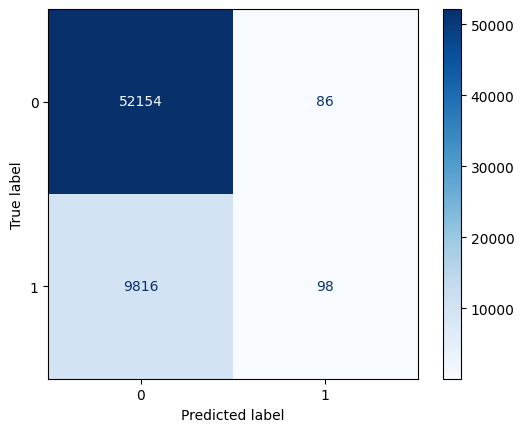

In [12]:
y_pred_prob = model.predict(X)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.4f}")

print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()